<h2>IOD와 IOBM</h2>
IOD(Indian Ocean Dipole) 란? <br>

<ul>
<li></li>
</ul>

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import sys
from matplotlib.patches import Rectangle
from netCDF4 import Dataset
from data_process import Data_processing

/tmp/ipykernel_809538/3784853972.py:15: RuntimeWarning: Mean of empty slice
  sst_climatology_jan = np.nanmean(sst[:,0,:,:], axis=0)


(70, 73, 144)
(73, 144)


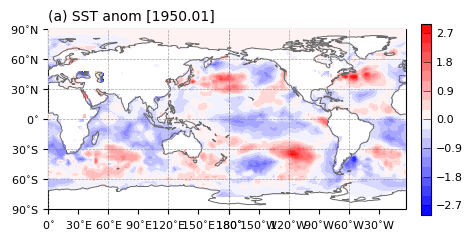

In [87]:
# 클래스를 만들어 쓰기 전 ~~
o_path = '/home/inhye_yoo/edu/datasets/'
o_name = 'ERA.sst.1950_2019.nc'

f = Dataset(o_path+o_name)
f.set_auto_mask(False)
    
sst = f.variables['p'][:]
sst = sst.reshape(-1,12,73,144)

# 결측치 처리
sst = np.where(sst==-9.99e+08, np.nan, sst)
sst_jan = sst[:,0,:,:]
#1950년 ~ 2019년 1월 평균 SST(기후평균, 73, 144)
sst_climatology_jan = np.nanmean(sst[:,0,:,:], axis=0)

# sst의 아노말리 구하기
sst_anom = sst_jan - sst_climatology_jan
print(sst_anom.shape)

sst_anom = sst_anom[1,:,:]
print(sst_anom.shape)

# plot
cmap = plt.colormaps['bwr']    # blue-white-red 색상 맵맵
clevs = np.arange(-3.0, 3.001, 0.3) # clevs는 등치선(contour level) 설정정
vm = 3.0
vn = -3.0

# make grid/ 위도- 경도 좌표를 생성하고, 지도 좌표계를 설정하며, 격자선을 추가하는 부분분
x, y = np.meshgrid(np.arange(0, 360.0, 2.5), np.arange(-90.0, 92.5, 2.5)) # 경도(x)와 위도(y) 격자점을 생성성
fig = plt.figure(figsize = (11, 8.5))                                     # 지도 객체 생성
ax = fig.add_subplot(2, 2, 1, projection = ccrs.PlateCarree(central_longitude=180.0)) # 2X2 서브플롯(grid) 중 첫번째(1번) 플롯을 생성
grd = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                        linewidth=0.5, linestyle='dashed', color='gray', alpha=0.7, zorder=7)

# 경도, 위도 눈금을 30도 간격으로 생성
lon_ticks = np.arange(-180, 181, 30)
lat_ticks = np.arange(-90, 91, 30)

# 위도 눈금 위치 설정
grd.ylocator = mticker.FixedLocator(lat_ticks)
ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

# 경도 및 위도 눈금 포맷 설정정
lon_fmt = LongitudeFormatter(number_format='.0f', degree_symbol=r'$^{\circ}$')
lat_fmt = LatitudeFormatter(number_format='.0f', degree_symbol=r'$^{\circ}$')
ax.xaxis.set_major_formatter(lon_fmt)
ax.yaxis.set_major_formatter(lat_fmt)
plt.setp(ax.get_xticklabels(), fontsize=8)
plt.setp(ax.get_yticklabels(), fontsize=8)

# 해안선따라 선긋기기
ax.coastlines(linewidth=0.7, color='dimgray', zorder=7)
plt.title('(a) SST anom [1950.01]', loc='left', fontsize=10)

# 첫번째 아노말리 그래프
cax = plt.contourf(x, y, sst_anom , levels=clevs, cmap=cmap, transform=ccrs.PlateCarree(), zorder=4)

# 컬러바의 위치와 크기 설정
cbar = plt.colorbar(cax, orientation='vertical', fraction=0.025, pad=0.04)
cbar.ax.tick_params(labelsize=8, direction='in', length=6, width=0.4, color='black', zorder=6)

plt.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9, hspace=0.1, wspace=0.3)
plt.show()
plt.savefig(o_path+o_name+'.png', dpi=300)
plt.close()

(29, 73, 144)
(29,)


/tmp/ipykernel_809538/1309427356.py:11: RuntimeWarning: Mean of empty slice
  climatology = np.nanmean(sst, axis=0)  # 월별 평균 (12, 73, 144)


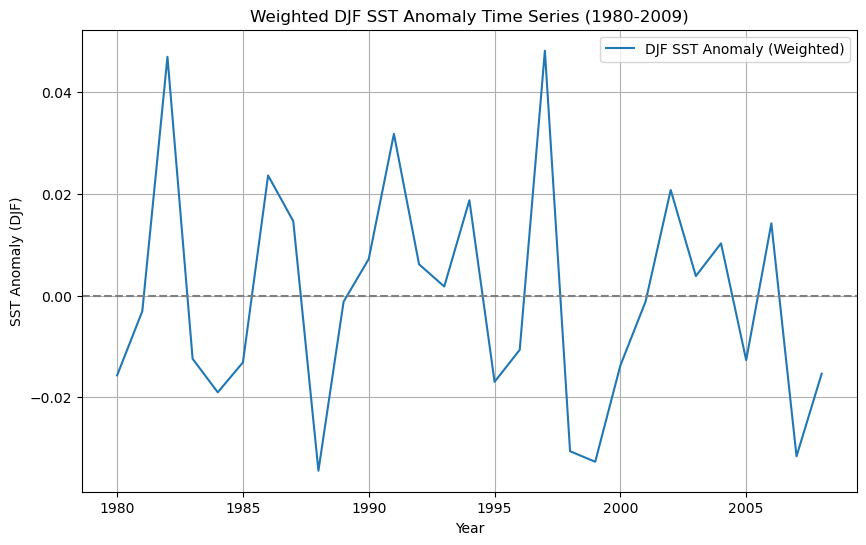

In [88]:
# 데이터 로드
p = Data_processing(o_path+o_name)
# f = Dataset(o_path + o_name)
# f.set_auto_mask(False)

# 변수 추출
_, sst = p.get_data('p', '198001-201012')
# print(sst.shape)

# 기후 기준값 (climatology) 계산 후 아노말리 추출
climatology = np.nanmean(sst, axis=0)  # 월별 평균 (12, 73, 144)
anom = sst - climatology  # 아노말리 계산

# DJF 데이터 추출
nino = np.append(anom[:-1], anom[1:], axis=1)  # 한 해의 12월 + 다음 해의 1,2월
djf = np.mean(nino[:, 11:14], axis=1)  # 12, 1, 2월 평균

print(djf.shape)

# # 위도 가중 평균 계산
idx_djf = p.region_mean(data_list=djf, nino34=True)
print(idx_djf.shape)
# 연도 설정 (1980-2009)
years = np.arange(1980, 2009)

# 시계열 플롯 만들기
plt.figure(figsize=(10, 6))
plt.plot(years, idx_djf, linestyle='-', label="DJF SST Anomaly (Weighted)")
plt.axhline(0, color='gray', linestyle='--')  # 0 기준선 추가
plt.xlabel('Year')
plt.ylabel('SST Anomaly (DJF)')
plt.title('Weighted DJF SST Anomaly Time Series (1980-2009)')
plt.grid(True)
plt.legend()
plt.show()


In [89]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.


In [90]:
def visualization(cbottom=0.15,figsize=(11,11),vm=0, vn=0, nrows=0, ncols=0, data=None, title=None, subtitle=None, clevs=None):
    # plot
    # cmap = plt.colormaps['bwr']             #Blue-white-red 색상맵맵
    clevs = clevs     # clevs는 등치선(contour level)
    vm = vm
    vn = vn

    nrows = nrows
    ncols = ncols

    # make grid 위도-경도 좌표를 생성하고, 지도 좌표계를 설정하며, 격자선을 추가하는 부분
    x, y = np.meshgrid(np.arange(0,360.0, 2.5), np.arange(-90.0, 92.5, 2.5))
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                            subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},
                            figsize=figsize)

    # 경도, 위도 눈금을 30도 간격으로 생성
    lon_ticks = np.arange(-180, 181, 60)
    lat_ticks = np.arange(-90, 91, 30)

    # 위도 눈금 위치 설정
    grd.ylocator = mticker.FixedLocator(lat_ticks)

    axs=axs.flatten()

    for i, data in enumerate(data):
        # data = correlation_matrix[i][:,:,:]
        # print(data)
        # data, lons = add_cyclic_point(correlation_matrix[i],coord=data['lon'])
        cs = axs[i].contourf(x, y, data , levels=clevs, cmap='bwr', 
                            transform=ccrs.PlateCarree(), zorder=4, extend='both')
        axs[i].set_title(title[i])

        #해안선 따라 선긋기
        axs[i].coastlines(linewidth=0.7, color='dimgray', zorder=7)

        # ㅣlon
        axs[i].set_xticks(lon_ticks, crs=ccrs.PlateCarree())
        lon_fmt = LongitudeFormatter(number_format='.0f', degree_symbol=r'$^{\circ}$')
        axs[i].xaxis.set_major_formatter(lon_fmt)
        axs[i].tick_params(axis='x', labelsize=8)

        # lat
        axs[i].set_yticks(lat_ticks, crs=ccrs.PlateCarree())
        lat_fmt = LatitudeFormatter(number_format = '.0f', degree_symbol=r'$^{\circ}$')
        axs[i].yaxis.set_major_formatter(lat_fmt)
        axs[i].tick_params(axis='y', labelsize=8)

        # axs[i].setp(ax.get_xticklabels(), fontsize=8)
        # axs[i].setp(ax.get_yticklabels(), fontsize=8)

    space = nrows * ncols
    print(space, len(title))
    if space != len(title):
         for i in range(space, -1, -1):
            print(i)
            fig.delaxes(axs[i-1])
            space -= 1
            if space == len(title):
                break
                
    fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9, hspace=0.1, wspace=0.3)
    # cax2 = plt.contourf(x, y, correlation_matrix[2] , levels=clevs, cmap=cmap, transform=ccrs.PlateCarree(), zorder=4)

    # 컬러바의 위치와 크기 설정
    cbar_ax = fig.add_axes([0.2, cbottom, 0.6, 0.02])

    cbar =fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=8, direction='in', length=8, width=0.4, color='black', zorder=6)

    plt.suptitle(subtitle)
    plt.show()
    plt.savefig(o_path+o_name+'.png', dpi=300)
    plt.close()

(30, 12, 73, 144)
functionnp.mean(data[:, 2:5], axis=1) (30, 73, 144)


/home/inhye_yoo/edu/code/training/data_process.py:82: RuntimeWarning: Mean of empty slice
  climatology = np.nanmean(data_add, axis=0)


6 5
6


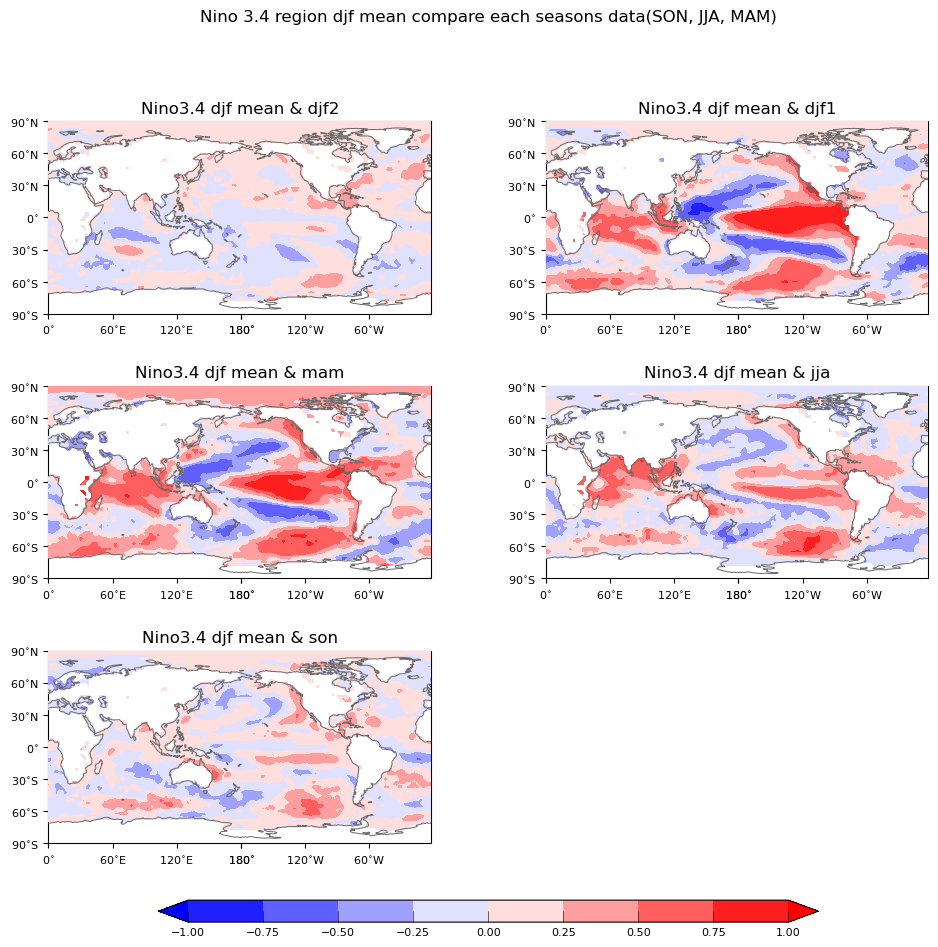

In [95]:
djf_mean = idx_djf
# 계절별 데이터 슬라이싱
season = ['djf2', 'djf1', 'mam', 'jja', 'son']

# 계절별 데이터 뽑기기
djf2, djf, mam, jja, son = p.season_process(*season, anom_list=anom) 
# print(djf2.shape, mam.shape, jja.shape, son.shape)

def corr(x,y):
    x = x[:, np.newaxis, np.newaxis]  # 차원 확장
    # y = y[:, :, :]  # y의 첫 번째 차원 크기를 29로 맞춤
    xy = np.mean(x*y, axis=0)
    xx = np.mean(x**2, axis=0)
    yy = np.mean(y**2, axis=0)
    cor = xy/np.sqrt(xx*yy)
    return cor
# print(djf_mean.shape, mam)
# print(corr(djf_mean, mam).shape)
# 상관계수 배열을 하나로 합침
correlation_matrix = [corr(djf_mean, season) for season in [djf2, djf, mam, jja, son]]
subtitle = 'Nino 3.4 region djf mean compare each seasons data(SON, JJA, MAM)'

title = [f'Nino3.4 djf mean & {title}' for title in season]
clevs = np.arange(-1.0, 1.001, 0.25)
visualization(vm=1, vn=-1, nrows=3, ncols=2, data=correlation_matrix, title=title, subtitle=subtitle, clevs=clevs)


6 5
6


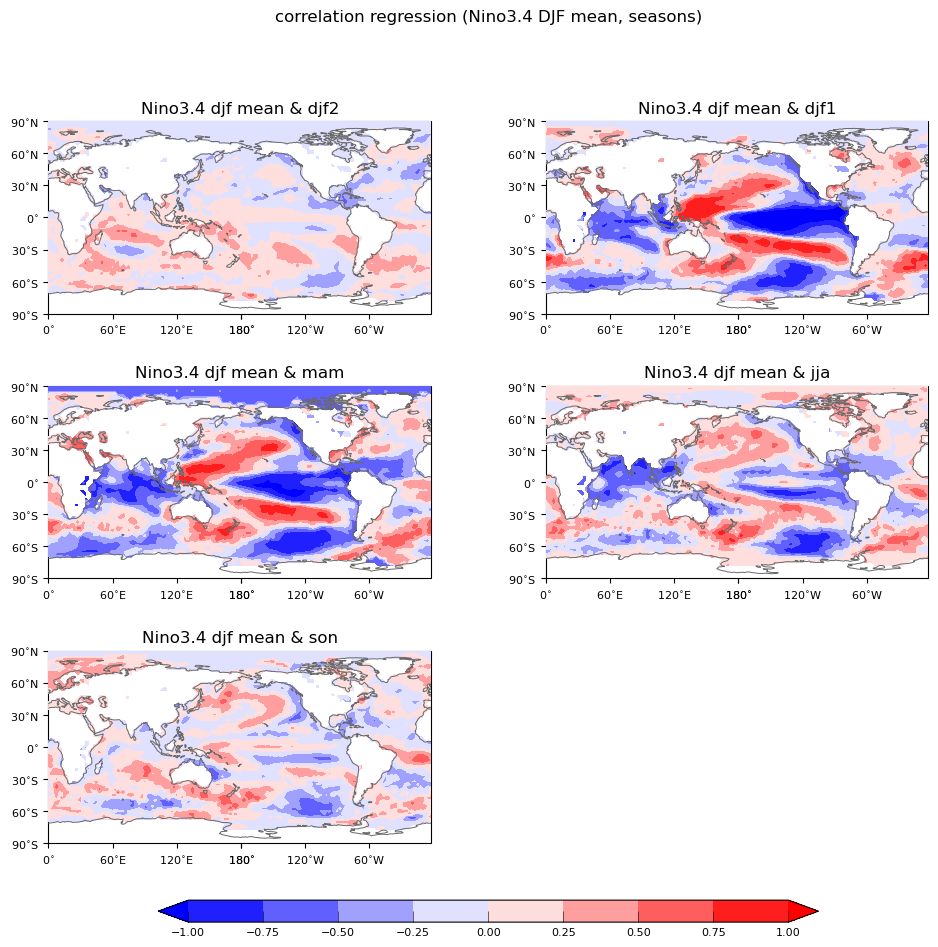

In [96]:
def reg(x, y):
    x = x[:, np.newaxis, np.newaxis]  # 차원 확장
    xy = np.mean(x*y, axis=0)
    xx=np.mean(x**2, axis=0)

    reg = xy/xx
    return reg

regression_matrix = [reg(djf_mean, season) for season in correlation_matrix]

# 회귀 계수 시각화
subtitle = 'correlation regression (Nino3.4 DJF mean, seasons)'
clevs = np.arange(-1.0, 1.001, 0.25)
visualization(vm=3, vn=-3, nrows=3, ncols=2, data=regression_matrix, title=title, subtitle=subtitle, clevs=clevs)

[[301.7661  301.88776 301.9173  301.89032 301.96146 301.8688  301.93253
  301.832   301.78812]
 [301.65512 301.7602  301.8588  301.9199  301.96265 301.8061  301.7991
  301.708   301.70422]
 [301.7662  301.76807 301.72406 301.65805 301.63315 301.4892  301.5867
  301.41742 301.37714]
 [302.06726 302.1802  302.27612 302.3176  302.40442 302.2768  302.19086
  302.0329  301.95447]
 [301.45352 301.50476 301.59833 301.68756 301.7805  301.63074 301.58112
  301.48306 301.46207]
 [301.48068 301.55835 301.6675  301.76343 301.87326 301.8629  301.84387
  301.77682 301.74057]
 [301.30005 301.43182 301.50906 301.53885 301.59235 301.5484  301.63013
  301.5419  301.56577]
 [301.87064 301.88907 301.8895  301.82916 301.8061  301.7685  301.93454
  301.8537  301.81842]
 [301.75363 301.80698 301.85556 301.9273  301.94727 301.81372 301.8679
  301.77252 301.81644]
 [301.44537 301.55057 301.65793 301.76477 301.85144 301.71417 301.89853
  301.86887 301.85272]
 [301.73166 301.8257  301.9079  301.92233 301.9123  3

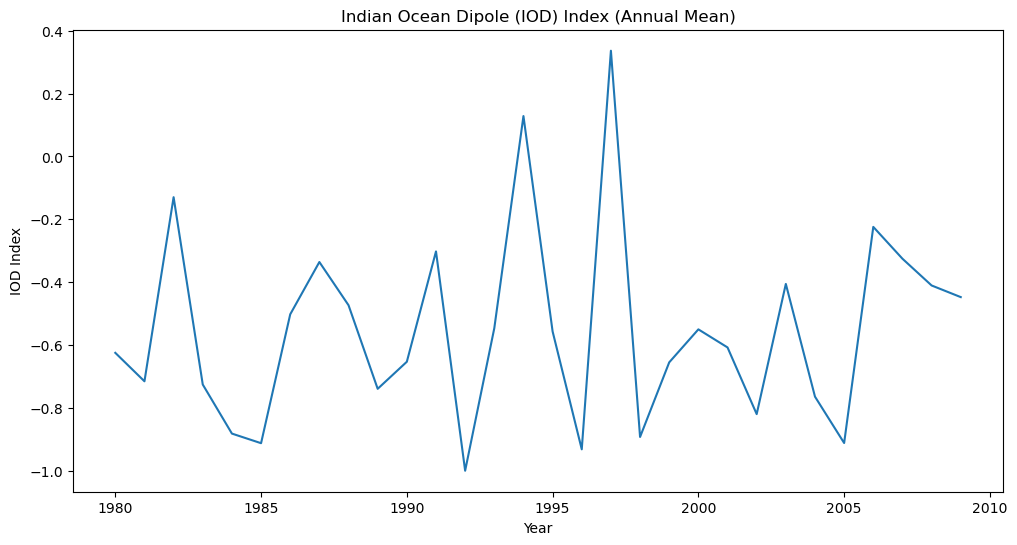

In [97]:
def range_idx(lat, lon):
    latitudes = np.arange(-90, 92.5, 2.5)
    longitudes = np.arange(0, 360, 2.5)

    latitude_indices = np.where((latitudes >= lat[0]) & (latitudes <= lat[1]))[0]
    longitude_indices = np.where((longitudes >= lon[0]) & (longitudes <= lon[1]))[0]
    return latitude_indices, longitude_indices

# 데이터에서 IOD Index 계산
west_latitudes, west_longitude = range_idx([-10,10],[50,70])
east_latitudes, east_longitude = range_idx([-10,0],[90,110])

lat = np.arange(-90, 92.5, 2.5)  # 위도 배열 생성
lat = np.cos(np.radians(lat))  # 위도에 따른 가중치 계산
lat = np.full_like(sst, lat[np.newaxis, ..., np.newaxis])
lat = np.where(np.isnan(sst)==True, np.nan, lat)

pick_west_data = sst[:,:,32:41,20:29]
pick_west_lat = lat[:,:,32:41,20:29]

west_idx = np.nansum(pick_west_data * pick_west_lat, axis=(1,2))/ np.nansum(pick_west_lat, axis=(1,2))

pick_east_data = sst[:,:,east_latitudes[0]:east_latitudes[-1]+1,east_longitude[0]:east_longitude[-1]+1]
pick_east_lat = lat[:,:,east_latitudes[0]:east_latitudes[-1]+1,east_longitude[0]:east_longitude[-1]+1]

east_idx = np.nansum(pick_east_data * pick_east_lat, axis=(1,2))/np.nansum(pick_east_lat, axis=(1,2))
print(east_idx)
# IOD Index 계산
iod_index = west_idx - east_idx  # (년, 월)

print(iod_index.shape)
# 연도별 평균으로 변환하여 1D로 만들기
iod_index_mean = np.nanmean(iod_index, axis=1)  # (년,)

# X축: 연도 (1D)
years = np.arange(1980, 2010) #+ 2000  # 예: 2000년부터 시작한다고 가정

# 그래프 그리기
plt.figure(figsize=(12,6))
# plt.fill_between(years, iod_index, where=(iod_index > 0), color='red', alpha=0.7)
# plt.fill_between(years, iod_index, where=(iod_index < 0), color='blue', alpha=0.7)
# plt.axhline(0, color='black', linestyle='--')
plt.plot(years,iod_index_mean)
plt.xlabel("Year")
plt.ylabel("IOD Index")
plt.title("Indian Ocean Dipole (IOD) Index (Annual Mean)")
plt.show()


/tmp/ipykernel_809538/2329205245.py:3: RuntimeWarning: Mean of empty slice
  climatology = np.nanmean(sst, axis=0)  # 월별 평균 (12, 73, 144)
/tmp/ipykernel_809538/2329205245.py:6: RuntimeWarning: Mean of empty slice
  idx = np.nanmean(anom, axis=1)


4 2
4
3


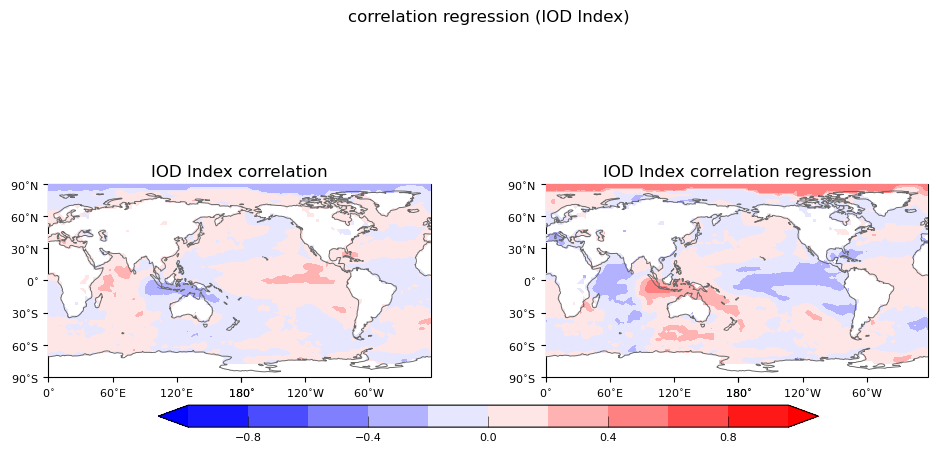

In [98]:
_, sst = p.get_data('p', '198001-201012')

climatology = np.nanmean(sst, axis=0)  # 월별 평균 (12, 73, 144)
anom = sst - climatology  # 아노말리 계산

idx = np.nanmean(anom, axis=1)
cor = corr(iod_index_mean, idx)
regr = reg(iod_index_mean, cor)

matrix = [cor, regr]
title = ['IOD Index correlation', 'IOD Index correlation regression']

subtitle = 'correlation regression (IOD Index)'
clevs = np.arange(-1.0, 1.001, 0.2)
visualization(cbottom=0.6,vm=3, vn=-3, nrows=2, ncols=2, data=matrix, title=title, subtitle=subtitle, clevs=clevs)